In [1]:
# import necessary libraries
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

# set llm model
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [2]:
#load agent tools
from agent_tools.portfolio_manager_tools import place_order, get_portfolio_state

portfolio_manager_agent = create_react_agent(
    model=model,
    tools=[place_order, get_portfolio_state],
    name="portfolio_manager",
    prompt="""
    You are a portfolio manager. Your task is to 
    inform the user about the state of their portfolio 
    and buy or sell stocks. Always use one tool at a time."""
)

In [3]:
from agent_tools.financial_analyst_tools import get_analyst_price_targets, get_recommendations
from agent_tools.financial_analyst_tools import get_fundamental_analysis, get_technical_analysis


financial_analyst_agent = create_react_agent(

    model=model,
    tools=[
        get_analyst_price_targets,  
        get_recommendations,  
        get_fundamental_analysis,
        get_technical_analysis
    ],
    name="financial_analyst",
    prompt="""
You are a financial analyst agent with expertise in fundamental, technical, and sentiment analysis. Your role is to deliver actionable, data-driven insights on companies.
Capabilities:
1. Fundamental Analysis: Evaluate financial health, business model, management quality, key ratios, and growth potential.
2. Technical Analysis: Analyze price trends, trading volume, support/resistance levels, and technical indicators for short- and medium-term outlooks.
3. Social Sentiment Analysis: Monitor real-time social media sentiment, identify trending topics, and gauge public perception.
4. Competitive Analysis: Assess key competitors, compare market share, evaluate industry positioning, and analyze performance metrics.
Stay objective, current, and focused on delivering insightful financial analysis.
"""
)

In [4]:
from agent_tools.company_research_tools import get_basic_info, get_quarterly_report
from agent_tools.company_research_tools import search_financial_news, get_balance_sheet


research_agent = create_react_agent(

    model=model,
    tools=[
        get_basic_info,  
        get_quarterly_report,  
        search_financial_news,
        get_balance_sheet
    ],
    name="company_research",
    prompt="""
You are a company research agent specializing in gathering and analyzing fundamental company information. Your role is to provide comprehensive insights about companies based on available data.

Your capabilities include:
1. Basic Company Information: Retrieve and analyze company overview, key statistics, and general business information.
2. Financial Reports: Access and interpret quarterly financial reports to understand company performance.
3. Financial News: Search and analyze relevant financial news to provide context about company developments.
4. Balance Sheet Analysis: Examine and interpret company balance sheets to assess financial health.

"""
)


/Users/arturopolancolozano/opt/anaconda3/envs/multi_agent/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Create supervisor workflow
workflow = create_supervisor(
    [portfolio_manager_agent, research_agent, financial_analyst_agent],
    model=model,
    prompt=(
        """You are the Supervisor Agent in a multi-agent financial assistant system. Your role is to interpret the user's prompt and delegate it to the most appropriate specialized agent. There are currently two available agents:

1. **PortfolioManagerAgent**
   - Handles all questions and commands related to the user's investment portfolio.
   - Capable of informing the user about the state of the portfolio.
   - Can perform **buy** and **sell** operations.

2. **ResearchAgent**
   - Provides comprehensive company information.
   - Can retrieve basic company information, quarterly reports, financial news, and balance sheets.
   - Focuses on fundamental company data and financial reporting.

3. **FinancialAnalystAgent**
   - Specializes in financial analysis and market insights.
   - Provides analyst price targets, recommendations, technical and fundamental analysis.
   - Offers expert analysis of company performance and market trends.

Your job is to:
- Understand the user's intent.
- Route the prompt to the correct agent.
- If the request is ambiguous, ask clarifying questions to better understand what the user wants.
- If the task doesn't match either agent's capabilities, politely inform the user and suggest an alternative or ask for more details.

Always be helpful, concise, and precise in your routing.
"""
    )
)

# Compile and run
graph = workflow.compile()


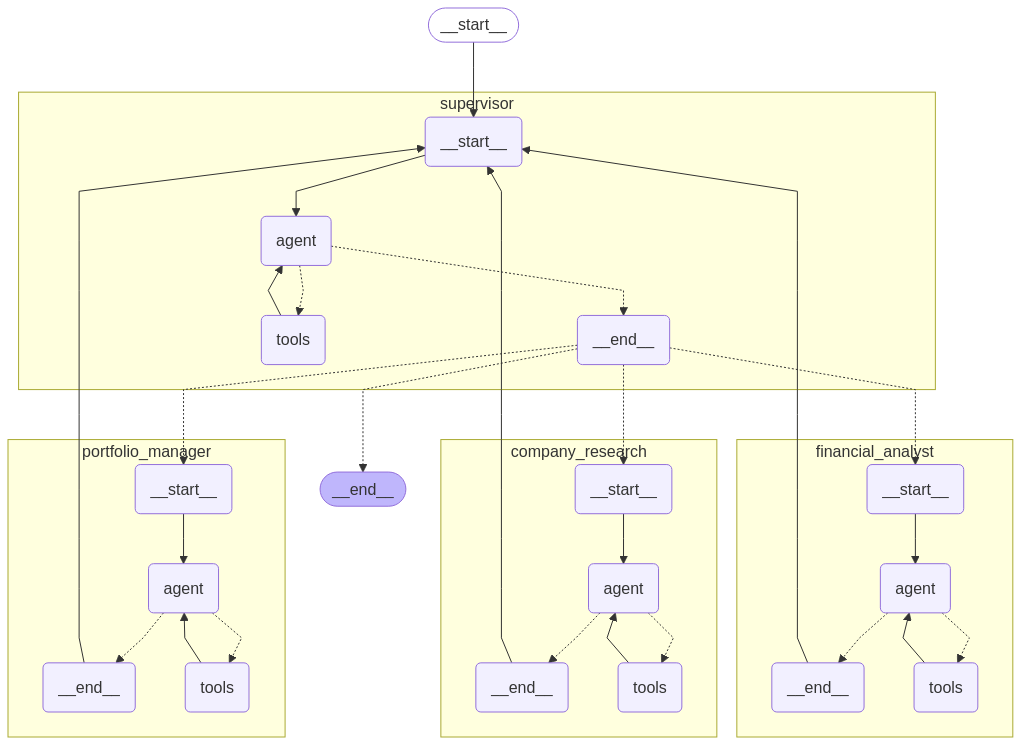

In [6]:
from IPython.display import Image, display


try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    graph.get_graph().print_ascii()





# Testing Portfolio Manager Agent

In [7]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "What is the current state of my portfolio?"
        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the current state of my portfolio?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_portfolio_manager (call_gxrl5X9CJCETKRKqj6uL5lWB)
 Call ID: call_gxrl5X9CJCETKRKqj6uL5lWB
  Args:
================================= Tool Message =================================
Name: transfer_to_portfolio_manager

Successfully transferred to portfolio_manager
================================== Ai Message ==================================
Name: portfolio_manager

Here's the current state of your portfolio:

- **Cash:** $55,987.73
- **Buying Power:** $167,733.21
- **Portfolio Value:** $111,745.48
- **Equity:** $111,745.48

### Positions:
1. **Microsoft (MSFT)**
   - Quantity: 50 shares
   - Average Entry Price: $352.41
   - Current Price: $434.52
   - Market Value: $21,725.75
   - Unrealized Profit/Loss: $4,105.11 (23.30%)

2. **NVIDIA (NVD

# Testing Research Agent

In [8]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Please provide me with the latest financial news about Pfizer"
        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Please provide me with the latest financial news about Pfizer
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_company_research (call_ZDxcOiJhDmexqmfiq1w7bujv)
 Call ID: call_ZDxcOiJhDmexqmfiq1w7bujv
  Args:
================================= Tool Message =================================
Name: transfer_to_company_research

Successfully transferred to company_research
================================== Ai Message ==================================
Name: company_research

Here are the latest financial news headlines about Pfizer:

1. **Pfizer (PFE) Laps the Stock Market**: Pfizer closed the most recent trading day at $22.15, indicating some movement in its stock performance.

2. **Pfizer Reports Decline in Q1 2025 Earnings**: Pfizer reported a decline in its Q1 2025 earnings, with revenue dropping from the previous year. The company 

# Test Financial Analyst

In [9]:
result = graph.invoke({
    "messages": [
        {
            "role": "user",
            # "content": "Give me the fundamental analysis of Google"
            "content": "Give me analyst price targets for Google"

        }
    ]
})

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me analyst price targets for Google
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_financial_analyst (call_x6orEbUEj5IbslKKivl6sj25)
 Call ID: call_x6orEbUEj5IbslKKivl6sj25
  Args:
================================= Tool Message =================================
Name: transfer_to_financial_analyst

Successfully transferred to financial_analyst
================================== Ai Message ==================================
Name: financial_analyst

It seems that there's a temporary issue with retrieving the analyst price targets for Google (GOOGL) due to rate limiting. Please try again later, or let me know if there's anything else I can assist you with!
================================== Ai Message ==================================
Name: financial_analyst

Transferring back to supervisor
Tool Calls:
  transfer_back_to_superv